In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = None

In [67]:
def load() -> pd.DataFrame:
    df = pd.read_pickle("new_data.pickle")

    outsample = df[df["Date Announced"] > "2020-01-01"] # true out of sample, do not touch
    insample = df[df["Date Announced"] <= "2020-01-01"]

    return outsample, insample 

_, df = load()

In [68]:
# process helper features

df["Acquiror is Tradable"] = (~df["Acquiror Primary Ticker Symbol"].isnull()) & (~df["Acquiror\'s price per share"].isnull()) & (~df["Exchange Ratio"].isnull())
df["Acquiror is Tradable"].value_counts()

False    734
True     462
Name: Acquiror is Tradable, dtype: int64

In [69]:
df.head()

,Success,Date Announced,Date Effective,Date Withdrawn,Deal Number,Target Name,Target Primary Ticker Symbol,Target Industry Sector,Acquiror Name,Acquiror Primary Ticker Symbol,Acquiror Industry Sector,Exchange Ratio,Price Per Share,Acquiror's price per share,Acquiror Closing Price 1 Day After Ann Date ($),Acquiror Closing Price 60 Days After Ann Date ($),Acquiror Closing Price 90 Days After Ann Date ($),Acquiror Closing Price 180 Days After Ann Date ($),Target Share Price 1 Day Prior to Announcement ($),Target Closing Price 1 Day After Ann Date ($),Target Closing Price 60 Days After Ann Date ($),Target Closing Price 90 Days After Ann Date ($),Target Closing Price 180 Days After Ann Date ($),Premium 1 day prior to announce- ment date,Premium 1 week prior to announce- ment date,Premium 4 weeks prior to ann. date,S&P 500 Closing Price 1 Day Before Announcement,Poison Pill,% sought,Ratio of Offer Price to EPS,Ratio of Deal Value to Sales,Ratio of Deal Value to EBIT,Ratio of Deal Value to EBITDA,Ratio of Deal Value to Net Income,Ratio of Enterprise Value to Sales,Ratio of Enterprise Value to EBIT,Ratio of Enterprise Value to EBITDA,Ratio of Enterprise Value to Net Income,Equity Value/ Net Sales,Ratio of Equity Value to EBIT,Ratio of Equity Value at Announcement to EBITDA,Ratio of Equity Value to Net Income,Target Ebit 3-Year Growth Rate (%),Target Ebit 5-Year Growth Rate (%),EBIT Margin,Target EBITDA Three Year Growth Rate,Target EBITDA Five Year Growth Rate,EBITDA Margin,Target Net Assets Three Year Growth Rate,Target Net Assets Five Year Growth Rate,Target Net Sales 5-Year Growth Rate (%),Total Fee %,Target Fee %,Target Total Assets 5-Year Growth Rate (%),Target Total Lia. 5-Year Growth Rate (%),Common Equity Multiple,Value / Net Assets,EBIT / Return on Assets,EBITDA ROA,Enterprise Value / Net Assets,Enterprise Value / Pre-tax Inc,Enterprise Value / Tangible Book Value,Ratio of Offer Price to Book Value,Target Net Sales LTM ($mil),EBIT Last Twelve Months ($ Mil),Pre-tax Income Last Twelve Months ($ Mil),Net Income Last Twelve Months ($ Mil),Target Net Assets ($mil),Target Total Assets ($mil),Target EBITDA LTM ($mil),Target Book Value Per Share LTM (US$),Target Common Equity ($mil),Target Earnings Per Share LTM (US$),Value Based on Effective Date ($mil),Value Common at Eff. Date ($mil),Equity Value at Effective Date ($mil),Target Book Value/sh One Year Prior,Target Book Value/sh Two Years Prior,Target Book Value/sh Three Years Prior,Target Capital Expend. One Year Prior ($ mil),Target Capital Expend. Two Years Prior ($ mil),Target Capital Expend. Three Years Prior ($ mil),Target Cash & Mktbl. Securities One Year Prior ($ mil),Target Cash & Mktbl. Securities Two Years Prior ($ mil),Target Cash & Mktbl. Securities Three Years Prior ($ mil),Host Curr. Target Long Term Debt One Year Prior (mil),Host Curr. Target Long Term Debt Two Years Prior (mil),Host Curr. Target Long Term Debt Three Years Prior (mil),Target Long- Term Liab. 1-Year Prior ($ mil),Target Long- Term Liab. 2-Years Prior ($ mil),Target Long- Term Liab. 3-Years Prior ($ mil),Target Net Cash Fr. Investing One Year Prior,Target Net Cash Fr. Investing Two Years Prior,Target Net Cash Fr. Investing Three Years Prior,Target Net Cash fr. Financing One Year Prior,Target Net Cash fr. Financing Two Years Prior,Target Net Cash fr. Financing Three Years Prior,Target Straight Debt One Year Prior ($ mil),Target Straight Debt Two Years Prior ($ mil),Target Straight Debt Three Years Prior ($ mil),Acquiror is Tradable
3,0,2012-01-13,NaT,2012-05-04,2379612020,Georgia Gulf Corp,GGC,Chemicals and Allied Products,Westlake Chemical Corp,WLK,Chemicals and Allied Products,NaN,35.00,NaN,56.340,65.690,61.120,54.010,24.48,33.48,33.07,32.06,27.23,42.97,62.94,89.39,1295.50,Yes,95.2,21.0,0.372,8.9,5.067,21.199,0.533,12.718,7.260,30.376,0.372,8.877,5.067,21.200,118.999,-7.857,0.042,27.36,-8.503,0.073,13.90,25.53,0.52,NaN,NaN,-7.09,-12.94,2.453,2.5,0.082,0.144,3.515,32.078,7.521,2.452,3222.884,135.038,5

In [70]:
'''
Backtest Computation logic:

4 Scenarios:

(1) Acquiror is Tradable
        // go short on acquiror for "Exchange Ratio" num of shares
        // go long on target for (1 + "Exchange Ratio") shares
    (A) Success = 0 (Merger Withdrawn)

        sell at 6mths

        annualised_return = pct_return / timedelta("Date Withdrawn" - "Date Announced")

    (B) Success = 1 (Merger Completed)
        abs_return_shortside = ("Acquiror Closing Price 1 Day After Ann Date ($)" - "Acquiror's price per share") * "Exchange Ratio"
        abs_return_longside = ("Price Per Share" - "Target Closing Price 1 Day After Ann Date ($)") * (1 + "Exchange Ratio")

        abs_return_total = abs_return_shortside + abs_return_longside
        pct_return = (abs_return_total - 1)

        annualised_return = pct_return / timedelta("Date Effective" - "Date Announced")

(2) Acquiror is NOT Tradable
        // go long on target only for 1 share
    (A) Success = 0 (Merger Withdrawn)
        abs_return_longside = ("Price Per Share" - "Target Closing Price 1 Day After Ann Date ($)")

        pct_return = abs_return_long - 1

        annualised_return = pct_return / timedelta("Date Withdrawn" - "Date Announced")

    
    (B) Success = 1 (Merger Completed)
        abs_return_longside = ("Price Per Share" - "Target Closing Price 1 Day After Ann Date ($)")

        pct_return = abs_return_long - 1

        annualised_return = pct_return / timedelta("Date Effective" - "Date Announced")
'''
pass

In [190]:
def calc_return(row: pd.Series) -> float:
    if row["Acquiror is Tradable"] == True:
        if row["Success"] == 0:
            tdelta = (row["Date Withdrawn"] - row["Date Announced"]).days

            if tdelta > 180:
                time_interval = "180 Days"
                t = 180
            elif tdelta > 90:
                time_interval = "180 Days"
                t = 180
            elif tdelta > 60:
                time_interval = "90 Days"
                t = 90
            else:
                time_interval = "60 Days"
                t = 60
            
            abs_return_shortside = ( (row["Acquiror Closing Price 1 Day After Ann Date ($)"] / row[f"Acquiror Closing Price {time_interval} After Ann Date ($)"]) - 1 ) * row["Exchange Ratio"]
            abs_return_longside = ( (row[f"Target Closing Price {time_interval} After Ann Date ($)"] / row["Target Closing Price 1 Day After Ann Date ($)"]) - 1 ) * (1 + row["Exchange Ratio"])
            abs_return_total = (abs_return_longside + abs_return_shortside) + 1
            annualised_return = ((abs_return_total)**(252/t)) - 1
        
        elif row["Success"] == 1:
            abs_return_shortside = ( (row["Acquiror Closing Price 1 Day After Ann Date ($)"] / row["Acquiror's price per share"]) - 1 ) * row["Exchange Ratio"]
            abs_return_longside = ( (row["Price Per Share"] / row["Target Closing Price 1 Day After Ann Date ($)"]) - 1 ) * (1 + row["Exchange Ratio"])
            abs_return_total = (abs_return_longside + abs_return_shortside) + 1
            tdelta = (row["Date Effective"] - row["Date Announced"]).days
            annualised_return = ((abs_return_total)**(252/tdelta)) - 1
    
    elif row["Acquiror is Tradable"] == False:
        if row["Success"] == 0:
            tdelta = (row["Date Withdrawn"] - row["Date Announced"]).days

            if tdelta > 180:
                time_interval = "180 Days"
                t = 180
            elif tdelta > 90:
                time_interval = "180 Days"
                t = 180
            elif tdelta > 60:
                time_interval = "90 Days"
                t = 90
            else:
                time_interval = "60 Days"
                t = 60

            abs_return_total = ( (row[f"Target Closing Price {time_interval} After Ann Date ($)"] / row["Target Closing Price 1 Day After Ann Date ($)"]))
            annualised_return = ((abs_return_total)**(252/t)) - 1
        
        elif row["Success"] == 1:
            abs_return_total = (row["Price Per Share"] / row["Target Closing Price 1 Day After Ann Date ($)"])
            tdelta = (row["Date Effective"] - row["Date Announced"]).days
            annualised_return = ((abs_return_total)**(252/tdelta)) - 1
    
    if abs(annualised_return) > 1:
        # placeholder for now to remove anomaly
        #print(row["Target Name"], row["Success"])
        annualised_return = np.nan

    return annualised_return

df["Backtest"] = df.apply(calc_return, axis=1)

## Dummy Strategy (Predict all Success, equal $ allocation)

Mean Returns:


Success
0   -0.019586
1    0.093457
Name: Backtest, dtype: float64

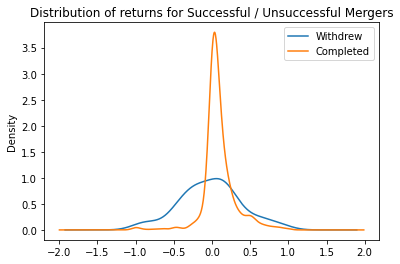

In [191]:
rets = df.groupby("Success").mean()["Backtest"]
print("Mean Returns:")
display(rets)

df[df["Success"] == 0]["Backtest"].plot.kde(label="Withdrew")
df[df["Success"] == 1]["Backtest"].plot.kde(label="Completed")
plt.title("Distribution of returns for Successful / Unsuccessful Mergers")
plt.legend()
plt.show()

## Stategy with binary classifier (equal $ allocation)

In [75]:
# TODO: implementation

## Strategy with binary classifier (probability weighted $ allocation)

In [76]:
# TODO: implementation